# Задание
_На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру._



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from statsmodels.stats import proportion
from statsmodels.stats.power import TTestIndPower

from scipy.stats import ttest_1samp, ttest_ind, mannwhitneyu, shapiro, pearsonr

Выполним подготовку данных

In [ ]:
df = pd.read_excel('AB_Test_Results (2).xlsx')

In [4]:
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


Основные статистические характеристики данных:

In [6]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


Определим количество пользователей в группах:

In [7]:
df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

Проверяем есть ли пользователи, которые попали в обе группы:

In [8]:
vardub = df.groupby('USER_ID', as_index=False).agg({
    'VARIANT_NAME': pd.Series.nunique
})

In [9]:
vardub.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


Пользователи, которые учитываются в обеих группах имеются. Исключим их и сохраним каждую групп в свою переменную:

In [10]:
more_than_one_var = vardub.query('VARIANT_NAME > 1')
df_new = df[~df.USER_ID.isin(more_than_one_var.USER_ID)].sort_values('USER_ID')
len(df_new)

6070

In [11]:
control = df_new.query('VARIANT_NAME == "control"')
len(control)

3026

In [12]:
test = df_new.query('VARIANT_NAME == "variant"')
len(test)

3044

Определим долю дублей в обеих группах:

In [13]:
pvar=(5016-3044)/5016
pvar

0.39314194577352474

In [14]:
pcont=(4984-3026)/4984
pcont

0.39285714285714285

Таким образом, мы видим что процент пользователей, которые попали в обе группы достаточно большой, почти 40%. Это говорит о низком качестве сплитования.

Проверяем данные на нормальность распеределия с помощью теста Шапиро-Уилка:

In [15]:
alpha = 0.05

st = shapiro(df.REVENUE)
print('Распределение {}нормальное \n'.format({True:'не ', False:''}[st[1] < alpha]))

Распределение не нормальное 



/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Построим графики распределений

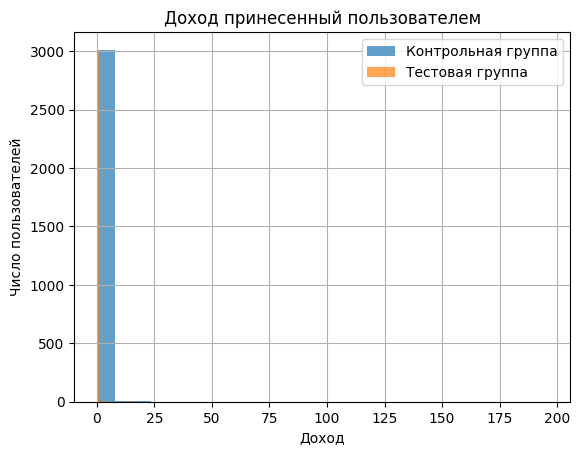

In [17]:
control.REVENUE.hist(bins = 25, alpha =0.7, label='Контрольная группа')
test.REVENUE.hist(bins = 25, alpha =0.7, label='Тестовая группа')
plt.title('Доход принесенный пользователем')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

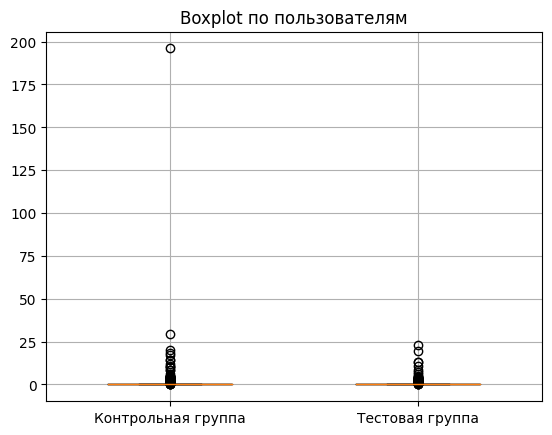

In [18]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контрольная группа','Тестовая группа'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis='both')

Выше видно, что распределение  в выборках не является нормальным. Используем критерий Манна-Уитнидля определения наличия статистичиски значимых отличий.

In [19]:
mw_stats = mannwhitneyu(x=control.REVENUE.values, y=test.REVENUE.values)
mw_stats

MannwhitneyuResult(statistic=4622832.0, pvalue=0.2444173738649208)

**Поскольку pvalue больше 5 %, то статистически значимых различий нет.**

Определим  мощность теста

$d=\frac{M1-M2}{S_{pooled}}$  

$S_{pooled}=\sqrt{\frac{S_1^2+S_2^2}{2}}$

In [27]:
ef = (test.REVENUE.mean()-control.REVENUE.mean()) / \
    np.sqrt((test.REVENUE.std() ** 2 + control.REVENUE.std() ** 2) / 2)
alpha = 0.05
TTestIndPower().solve_power(ef, power=None, nobs1=len(test), ratio=1.0, alpha=alpha)

0.290708584384403

Мощность теста слишком низкая.

***Рекомендации по результатам анализа эксперимента:***
1. Очень низкое качество сплитования пользователей. 39% пользователей попали в обе группы. Необходимо провести А/А тестирование  для контроля работы алгоритма сплитования и внести необходимые изменения в его работу.
2. Мощность теста слишком низкая. При планировании эксперимента нужно помнить, что мощность должна быть разумно высокой, чтобы обнаружить разумные отклонения от нулевой гипотезы. В противном случае, эксперимент не следует проводить.Необходимо продолжить эксперимент, а если он уже закончен, то провести его вновь с увеличенным сроком для выхода на требуемую мощность для достоверного определения влияния гипотезы на доход, принесенный пользователем.
3. По имеющимся данным результаты теста неудовлетворительные - увеличения дохода не наблюдается. На текущем этапе внесение изменений на сайт не целесообразно.